# Analisi verbalizzazioni

Questo *notebook* consente di svolgere alcune semplici analisi a partire dai verbali estratti tramite la funzione [Archivio verbali ed esiti finali](https://work.unimi.it/boDocenti/wicket/page?3) dell'applicazione [B.O. Docent](https://work.unimi.it/boDocenti/); più in generale consente di svolgere le analisi a partire da un qualunque elenco di verbali d'esame che registrino, per ciascuna prova, l'*insegnamento* a cui si riferisce, la *data* in cui è avvenuta, il numero di *matricola* dello studente (o un qualunque identificatore unico del medesimo) e l'*esito* della prova.

Per sapere come installare il software necessario ad eseguirlo seguite le istruzioni contenute nel `README.md` del repository che contiene il notebook.

In [1]:
# importazione delle librerie necessarie

import pandas as pd
from ipywidgets import widgets

## Lettura e preparazione dei dati

In questa sezione vengono caricati e "normalizzati" i dati che si assume siano stati ottenuti dall'esportazione sopra descritta e salvanti in un file il cui nome è memorizzato nella variabile `file_verbali`.

Eseguita l'ultima cella di questa sezione i dati saranno contenuti nella variabile `estrazione` che corrisponderà ad un *data-frame* di Pandas contenente le colonne: `Inesegnamento`, `Appello`, `Matricola` ed `Esito` ed ordinato per data dell'appello (l'ordine è rilevante per le aggregazioni delle prossime sezioni). Il contenuto della colonna `Eisto` è una *stringa* che codifica l'esito della prova come segue:

* `RI` corrisponde ad un ritiro,
* `RE` indica che la prova non è stata superata (ossia che l'allievo è stato respinto),
* un stringa contenente un numero intero corrisponde ad un esito verbalizzato (la stringa `33` corrisponde al voto 30 e lode),
* una stringa contenente un numero intero prefissato dal simbolo `~` corrisponde ad un esito rifiutato. 

In [2]:
file_verbali = 'verbali-esami.xls'

In [3]:
def vse2e(voto, stato_esito):
    if stato_esito == 'Rifiutato': return '~' + voto
    if voto == 'Respinto': return 'RE'
    if voto == 'Ritirato': return 'RI'
    if voto == '30 e lode': return '33'
    return voto

estrazione = pd.read_excel(file_verbali).apply(lambda _: pd.Series({
    'Insegnamento': _['Descrizione insegnamento'],
    'Appello': _['Data appello'],
    'Matricola': _['Matricola'], 
    'Esito': vse2e(_['Voto'], _['Stato Esito'])
}), axis = 1).sort_values('Appello')

In [4]:
# vengono riportate alcune linee a scopo di esempio

estrazione.head()

,Insegnamento,Appello,Matricola,Esito
378,LINGUAGGI E TRADUTTORI,2019-06-18,867234,24
376,LINGUAGGI E TRADUTTORI,2019-06-18,857113,24
377,LINGUAGGI E TRADUTTORI,2019-07-09,897293,24
374,LINGUAGGI E TRADUTTORI,2019-07-23,V06539,RE
375,LINGUAGGI E TRADUTTORI,2019-07-23,893396,30


## Selezione dei dati

Eseguendo le celle di questa sezione è possibile definire alcune funzioni di utilià che possono risultare comode per selezionare i dati di uno o più appelli dalla variabile `estrazioni` ottenuta in precedenza.

In particolare, la prossima cella ottiene gli insegnamenti a cui si riferiscono gli esiti.

In [5]:
insegnamenti = sorted(set(estrazione.Insegnamento))

Le prossime due funzioni consentono di ottenere l'elenco di appelli dato un insegnamento e l'elenco di verbali corrispondenti ad un certo insegnamento e appello.

In [6]:
def appelli(insegnamento):
    return tuple(sorted(set(estrazione[estrazione.Insegnamento == insegnamento].Appello.dt.date)))

def verbali(insegnamento, appelli):
    if not isinstance(appelli, tuple): appelli = (appelli, )
    return estrazione[(estrazione.Insegnamento == insegnamento) & estrazione.Appello.dt.date.isin(appelli)]

La prossima cella definisce una funzione che produce una serie di *widget* utili a selezionare un sottoinsieme di verbali in funzione dell'insegnamento e dell'appello. La funzione restituisce un oggetto i cui attributi: `insegnamento`, `appello` e `verbali` sono dinamicamente aggiornati per riflettere la selezione corrente. 

La parte a destra dei widget riporata il numero totale di verbali selezionai ed il numero di matricola uniche presenti, tale numero è minore di quello dei verbali qualora uno o più studenti figurino iscritti a più appelli.

In [7]:
def ui():

    wins = widgets.Select(description = 'Insegnamenti')
    wapp = widgets.SelectMultiple(description = 'Appelli')
    wlabel = widgets.HTML(description = 'Selezione')

    def uwapp(change):
        wapp.options = appelli(change.new)
        wapp.value = wapp.options 
    wins.observe(uwapp, names = 'value')

    def uselected(change):
        sel = verbali(wins.value, wapp.value)
        wlabel.value = "<b>Verbali</b>: {}<br/><b>Iscritti</b>: {}".format(len(sel), len(set(sel.Matricola)))
    wapp.observe(uselected, names = 'value')    

    wins.options = insegnamenti
    wins.value = insegnamenti[0]
    wapp.options = appelli(insegnamenti[0])
    wapp.options = wapp.value

    display(widgets.HBox([wins, wapp, wlabel]))
        
    return type('UISelection', (), {
        'insegnamento': property(lambda _: wins.value),
        'appelli': property(lambda _: wapp.value),
        'verbali': property(lambda _: verbali(wins.value, wapp.value)),
    })()
    
sel = ui()

In [8]:
# a titolo di esmepio, i primi verbali selezionati

sel.verbali.head()

,Insegnamento,Appello,Matricola,Esito
308,PROGRAMMAZIONE II,2020-01-21 14:30:00,922862,RE
307,PROGRAMMAZIONE II,2020-01-21 14:30:00,923089,~19
306,PROGRAMMAZIONE II,2020-01-21 14:30:00,943629,RE
305,PROGRAMMAZIONE II,2020-01-21 14:30:00,922735,RE
304,PROGRAMMAZIONE II,2020-01-21 14:30:00,922688,RE


### Nota bene

La variabile `sel` è aggiornata dinamicamente, il che significa in particolare che una volta modificate le selezioni nei widget riporatti sopra è sufficiente eseguire di nuovo *solo le celle delle seguenti sezioni* perché le relative analisi riflettano la nuova selezione.

## Analisi degli esiti unici

Dal momento che la selezione può contenere più verbali relativi allo stesso studente, questa sezione suggerisce un modo per riassumere i diversi esiti relativi a ciascuno studente; la funzione `euniq`, dato un elenco di esiti di un assegnato studente, restituisce:

* il voto (nel caso tra gli esiti sia presente una verbalizzazione), oppure
* il più alto voto rifiutato (nel caso ci sia almeno un rifiuto tra gli esiti), oppure
* `RE` qualora lo studente sia stato respinto almeno una volta, oppure
* `RI` qualora lo studente si sia sempre ritirato.

In [9]:
accetta = lambda _: _[0] in frozenset('0123456789') # determina se l'esito è stato accettato
rifiuta = lambda _: _.startswith('~') # determina se l'esito è stato rifiutato

def euniq(e):
    v = list(filter(accetta, e.values))
    if v: return v[0]
    v = list(filter(rifiuta, e.values))
    if v: return max(v)
    if 'RE' in e.values: return 'RE'
    if 'RI' in e.values: return 'RI'   

Usando la funzione `euniq` per aggregare i verbali raggruppati per numero di matriola, si ottiene la variabile `esiti_unici` che contiene una *serie* con un valore per matricola.

In [10]:
esiti_unici = sel.verbali.groupby('Matricola').Esito.agg(euniq)

Le due funzioni ausiliare seguenti consentono di ottenere rispettivamente un conteggio ed un istogramma degli esiti unici.

In [11]:
def count(_):
    return pd.DataFrame({'#': _.value_counts().sort_index()}).T

In [12]:
count(esiti_unici) # i valori riporatati sono numeri di verbali

,18,19,20,21,22,23,24,25,26,27,28,30,33,RE,RI,~19
#,9,6,8,4,5,3,4,2,2,2,6,4,1,56,23,1


In [13]:
def hist(_):
    perc = lambda _: (10000*_/sum(_)).astype(int)/100    
    perc(_.value_counts()).sort_index().plot.bar()

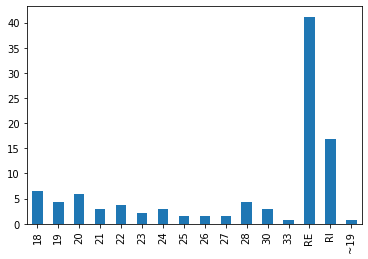

In [14]:
hist(esiti_unici) # i valori sono percentuali

### Più succintamente

Può essere utile "semplificare" i diversi esiti raggruppando nel valore `OK` tutti gli esiti vebralizzati e in `~` quelli rifiutati usando la funzione seguente 

In [15]:
def sempl(e):
    return 'OK' if accetta(e) else ('~' if e.startswith('~') else e)

In [16]:
esiti_unici_sempl = esiti_unici.apply(sempl)

In [17]:
count(esiti_unici_sempl)

,OK,RE,RI,~
#,56,56,23,1


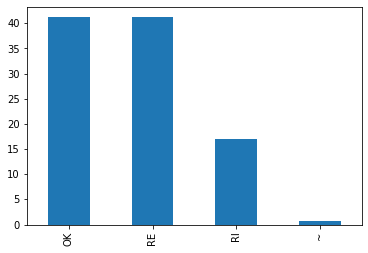

In [18]:
hist(esiti_unici_sempl)

## La "storia" degli esiti (pattern)

Invece di riassumere gli esiti relativi ad uno studente in un unico valore, può essere interessante conservare l'intera storia di tutti gli esiti; la cella seguente definisce la variabile `pattern` aggregando in una *tupla* gli esiti raggruppati per numero di matricola. 

In [19]:
pattern = sel.verbali.groupby('Matricola').Esito.agg(tuple)

In [20]:
pattern.head() # alcuni valori d'esempio

Matricola
903870                           (RE,)
917221                        (RE, RE)
922686    (RI, RI, RI, RI, RI, RI, RE)
922688                   (RE, ~18, 25)
922714                           (18,)
Name: Esito, dtype: object

Come osservato da Paolo Boldi (che ha proposto questa aggregazione in una analisi dei risultati dell'insegnamento di "Programmazione"), è bene eliminare dalle storie i singoli ritiri avvenuti nell'ultimo appello.

In [21]:
# le matricole degli iscritti all'ultimo appello tra quelli selezionati

iscr_ultimo_appello = set(sel.verbali[sel.verbali.Appello.dt.date == sel.appelli[-1]].Matricola)

# le matricole di chi ha ('RI', ) come pattern e s'è iscritto solo all'ultimo appello

solo_ri_ultimo_appello = set(pattern[pattern == ('RI', )].index) & iscr_ultimo_appello

In [22]:
# i pattern "ripuliti" secondo l'osservazione di Paolo

pattern_nori = pattern[set(pattern.index) - solo_ri_ultimo_appello]

In [23]:
# un confronto tra il numero di storie e storie "ripulite"

len(pattern), len(pattern_nori)

(136, 132)

Il primo dato interessante è la lunghezza di tali pattern, ossia il numero di volte che l'esame viene ripetuto

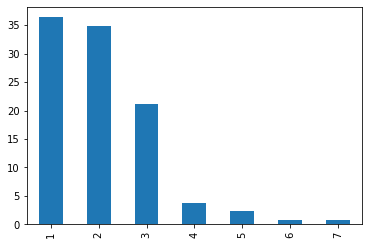

In [24]:
hist(pattern_nori.apply(len))

La funzione seguente consente invece di ottenere un elenco dei pattern ordinato secondo la frequenza con cui compare:

In [25]:
def freq(_):
    perc = lambda _: (10000*_/sum(_)).astype(int)/100    
    return pd.DataFrame({'%': perc(_.value_counts().sort_values(ascending = False))})

In [26]:
freq(pattern_nori).head(10) # ad esempio, i 10 più frequenti

,%
"(RE,)",13.63
"(RI,)",6.81
"(RE, RE)",6.81
"(RI, RI)",6.81
"(RE, RE, RE)",4.54
"(RI, RE, RE)",3.78
"(RI, RE)",3.78
"(RE, RI)",3.03
"(RE, RE, 20)",3.03
"(30,)",2.27


### Più succintamente

Come nel caso precedente, prima di costruire i pattern, può aver senso raccogliere gli esiti verbalizzati e rifiutati nei due valori `OK` e `~`

In [27]:
pattern_sempl = sel.verbali.Esito.map(sempl).groupby(sel.verbali.Matricola).agg(tuple)

In [28]:
pattern_sempl.head() # un esempio

Matricola
903870                           (RE,)
917221                        (RE, RE)
922686    (RI, RI, RI, RI, RI, RI, RE)
922688                     (RE, ~, OK)
922714                           (OK,)
Name: Esito, dtype: object

In [29]:
# applico la stessa pulizia di prima

pattern_sempl_nori = pattern_sempl[set(pattern_sempl.index) - solo_ri_ultimo_appello]

In [30]:
freq(pattern_sempl_nori).head(10)

,%
"(OK,)",15.90
"(RE,)",13.63
"(RE, OK)",9.09
"(RE, RE)",6.81
"(RI,)",6.81
"(RI, RI)",6.81
"(RE, RE, OK)",6.06
"(RE, RE, RE)",4.54
"(RI, RE, RE)",3.78
"(RI, OK)",3.78


Dall'elenco dei pattern semplificati è possibile ottenere un'altra informazione interessante: il numero di volte che l'esame è stato ripetuto da coloro i quali l'hanno passato

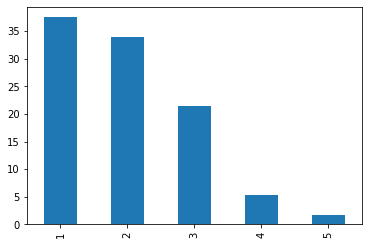

In [31]:
hist(pattern_sempl_nori[pattern_sempl_nori.apply(lambda _: _[-1] == 'OK')].apply(len))

Altre visualizzazioni possono essere ottenute tramite la seguente funzione

In [32]:
def hhist(_, figsize = (6, 4)):
    perc = lambda _: (10000*_/sum(_)).astype(int)/100    
    perc(_.value_counts()).sort_values().plot.barh(figsize = figsize)

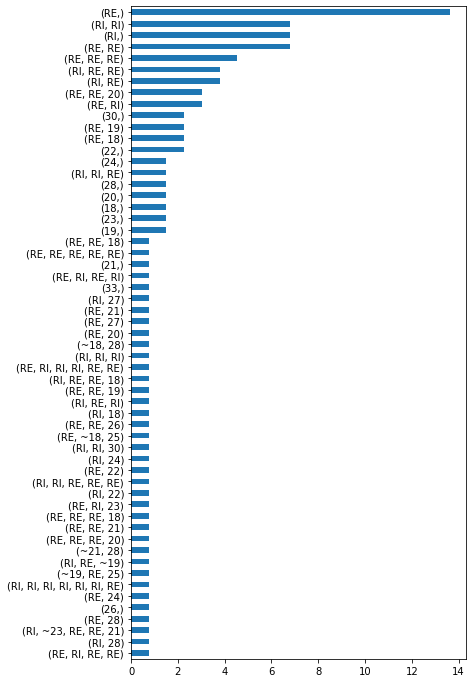

In [33]:
hhist(pattern_nori, (6, 12))

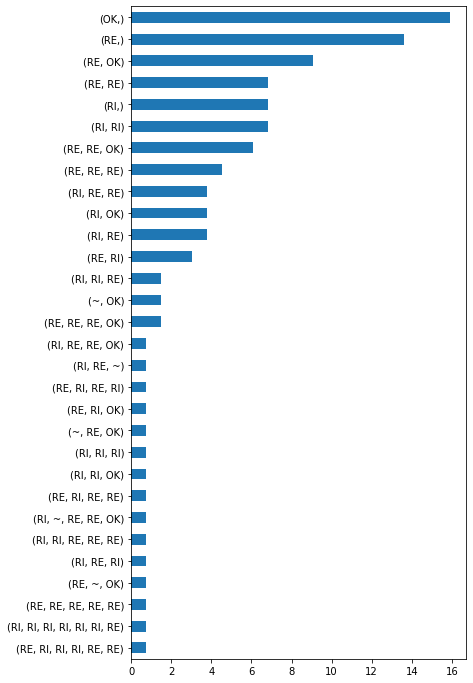

In [34]:
hhist(pattern_sempl_nori, (6, 12))